<font face="Calibri" size=5>Credit Valuation Adjustment on Derivative Instruments </font>

This is a Python 3 version of a CVA project.
- The project was done in a 5 person team, over multiple weeks, in a Financial Engineering course.
- The original code was in R, and much of the visual analysis was in Excel.
- This is my conversion, and revision of the R code - done individually.

<font color="blue">Goal: A report describing applied methodologies, as well as CVA calculations for different types of derivative insturments.</font>


<hr>

<font size=2>Global Imports</font>

In [1]:
# For data supplied frmo the market, etc
import pandas as pd

# Mostly to run a cubic spline interpolation
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate


<hr>

<font face="Calibri" size=4>Part 0. Description of the Derivative Instruments
</font>

- 1. Buy **EUR** sell PLN FX Forward  
(maturity: 1 year, notional: 100 000 EUR; strike: 4.3930)


- 2. Receiver (We receive fixed rate) PLN WIBOR 3M IRS  
(maturity: 3 years, notional: 500 000 PLN; fixed rate: 2.2144% - paid annually)


- 3. EUR/PLN CIRS, paid rate: fixed rate (-0,0575%) in EUR,  
received rate WIBOR 3M, notional exchange at the beginning as well as end of the contract  
(maturity: 3 years, notional: 100 000 EUR/ 430 000 PLN)

<font face="Calibri" size=4>Part I. Analysis of Instruments
</font>
- ### Mechanics
- ### Payoff formulars & Payoff Profiles
- ### Valuation Formulas

<font face="Calibri" size=4>Part II. Implied Defauly Probability
</font>
- ### CDS Contracts
  - Mechanics
  - Valuation
- ### Implying Probability of Default from a CDS spread
  - CDS bootsrapping
  - CDS bootstrapping from sample market quotes

_Bootsrapping is any test of metric that relies on random sampling with replacement. It allows assigning measures of accuracy __(defined in terms of bias, variance, confidence intervals, prediction error, etc)__ to sample estimates. This techinique allows estimation of the sampling distribution of almost any statistic, using ranomd sampling methods. (Wikipedia)_

<font color=#cc33ff>__[+] Data__</font>

In [2]:
# As CDS spreads are not readily available for free,
# this market data was supplied as part of the project.
# The data, oringinal in .xlsx, has been copied into Pandas DataFrames.

# Our CDS data has tenors of .5 years to 10 yrs. 
# We add a column for this length, in years

cds_data ={
    "CDS_DB":["DB6MEUSM=R", "DB1YEUSM=R", "DB2YEUSM=R", "DB3YEUSM=R",
              "DB4YEUSM=R", "DB5YEUSM=R", "DB7YEUSM=R","DB10YEUSM=R"],
    "CDS_Tenor":[0.5, 1, 2, 3, 4, 5, 7, 10],
    "Close" :[35.88, 39.40, 69.35, 96.70,
              123.33,152.07,196.58,223.30]}

Market_CDS_Spreads = pd.DataFrame(cds_data)
Market_EURPLN_Xr = 4.3000

# The index in this DataFrame represents the number of months into the future
Discount_Factors = pd.read_csv("discfac.csv")
# for ease of use, we also add timespan in years to the DscFctr dframe
Discount_Factors["DF_Tenor"] = [tm/12 for tm in range(61)]
Discount_Factors = Discount_Factors[["DF_Tenor","EUR_DF",
                                     "PLN_DF","EUR/PLN"]]

In [3]:
Discount_Factors

,DF_Tenor,EUR_DF,PLN_DF,EUR/PLN
0,0.000000,1.000000,1.000000,4.3000
1,0.083333,1.000395,0.998300,4.3090
2,0.166667,1.000639,0.997183,4.3149
3,0.250000,1.000881,0.995828,4.3218
4,0.333333,1.001156,0.994414,4.3292
...,...,...,...,...
56,4.666667,0.991033,0.892382,4.7754
57,4.750000,0.990337,0.890101,4.7842
58,4.833333,0.989622,0.887798,4.7932
59,4.916667,0.988889,0.885484,4.8021


In [6]:
print(Market_CDS_Spreads)
print("\nEUR/PLN :",Market_EURPLN_Xr,'\n')
#print("---- Discount_Factors ----\n")
#print(Discount_Factors.info())
#print(Discount_Factors.head(),'\n',Discount_Factors.tail())

        CDS_DB  CDS_Tenor   Close
0   DB6MEUSM=R        0.5   35.88
1   DB1YEUSM=R        1.0   39.40
2   DB2YEUSM=R        2.0   69.35
3   DB3YEUSM=R        3.0   96.70
4   DB4YEUSM=R        4.0  123.33
5   DB5YEUSM=R        5.0  152.07
6   DB7YEUSM=R        7.0  196.58
7  DB10YEUSM=R       10.0  223.30

EUR/PLN : 4.3 



Given the information in `Market_CDS_Spreads`, we would like to us an interpolaiton method, to create spread values for monthly intervals up to the duration of our longest insturment: 3 years.

The `Market_CDS_Spreads` serve as imput to a function for curve-fitting to find these intermediate values, not explicitly in the list of spread tenors. For this approximation, we will use a spline method; namely, cubic splines.

__Cubic Splines__  
For each $n$ points of data, the spline method fits a cubic function through the points. By through, we mean that specific points in the data must also lie on the function. Additionally, the method adds constrains/requirements that the first and secon derivatives if the curves fit over various intervals match. Even though, the process is peicewise, the added requirements create a smooth approximation.

In [7]:
# Load the CDS Tenors into a var
cdstenor_tm = Market_CDS_Spreads.CDS_Tenor
cdsspread_amt = Market_CDS_Spreads.Close

In [8]:
# Fit spline to the data. default for k = 3 for cubic. s is smoothing level
tck = interpolate.splrep(x = cdstenor_tm, y = cdsspread_amt, s=0)

In [9]:
tck

(array([ 0.5,  0.5,  0.5,  0.5,  2. ,  3. ,  4. ,  5. , 10. , 10. , 10. ,
        10. ]), array([ 35.88      ,  32.23146303,  67.57692568,  96.46494703,
        122.63642602, 193.41324605, 221.70253173, 223.3       ,
          0.        ,   0.        ,   0.        ,   0.        ]), 3)

We now use the fitted data to created interpolated points a the monthly intervals for our instruments.

In [10]:
# Load the 36 months time interval into a separate var
month_dur = Discount_Factors.DF_Tenor[:37]
month_dur[-3:]

34    2.833333
35    2.916667
36    3.000000
Name: DF_Tenor, dtype: float64

In [17]:
interp_CDS_amt = interpolate.splev(month_dur, tck, der=0)

In [18]:
interp_CDS_amt

array([48.93054304, 45.32036668, 42.32558519, 39.91517819, 38.05812526,
       36.72340599, 35.88      , 35.49688687, 35.54304619, 35.98745757,
       36.79910061, 37.94695488, 39.4       , 41.12721556, 43.09758115,
       45.28007637, 47.64368081, 50.15737408, 52.79013576, 55.51094546,
       58.28878276, 61.09262728, 63.89145859, 66.6542563 , 69.35      ,
       71.95433753, 74.46958967, 76.90474545, 79.26879389, 81.57072401,
       83.81952484, 86.0241854 , 88.19369471, 90.33704181, 92.4632157 ,
       94.58120543, 96.7       ])

$\uparrow$ Above, in `intepr_CDS_amt` we can see values from the `Close` column show up, as they should, for know tenor

$\downarrow$ Let's plot what's happened

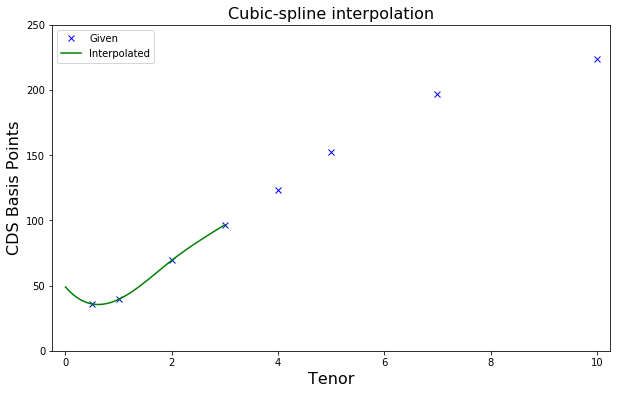

In [28]:
plt.figure(figsize=(10,6))
plt.plot(cdstenor_tm, cdsspread_amt, 'xb', month_dur, interp_CDS_amt, 'g')
plt.legend(['Given', 'Interpolated'])
plt.xlabel("Tenor",fontsize=16)
plt.ylabel("CDS Basis Points",fontsize=16)
plt.axis([-0.25, 10.25, 0, 250])
plt.title('Cubic-spline interpolation',fontsize=16)
plt.show()

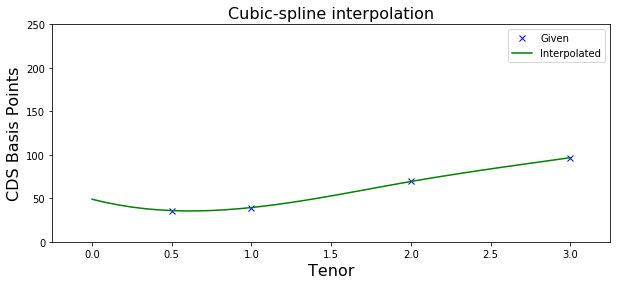

In [32]:
plt.figure(figsize=(10,4))
plt.plot(cdstenor_tm[:4], cdsspread_amt[:4], 'xb', month_dur, interp_CDS_amt, 'g')
plt.legend(['Given', 'Interpolated'])
plt.xlabel("Tenor",fontsize=16)
plt.ylabel("CDS Basis Points",fontsize=16)
plt.axis([-0.25, 3.25, 0, 250])
plt.title('Cubic-spline interpolation',fontsize=16)
plt.show()

The `interp_CDS_amt` array gives use one value for a CDS spread, per month, based on the observed initial quote data. We can not move forward to find Implied Default Probabilities.

In [20]:
x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
y = np.sin(x)
tck = interpolate.splrep(x, y, s=0)
xnew = np.arange(0, 2*np.pi, np.pi/50)
ynew = interpolate.splev(xnew, tck, der=0)

In [21]:
x

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714, 6.28318531])

In [22]:
y

array([ 0.00000000e+00,  7.07106781e-01,  1.00000000e+00,  7.07106781e-01,
        1.22464680e-16, -7.07106781e-01, -1.00000000e+00, -7.07106781e-01,
       -2.44929360e-16])

In [32]:
tck

(array([0.        , 0.        , 0.        , 0.        , 1.57079633,
        2.35619449, 3.14159265, 3.92699082, 4.71238898, 6.28318531,
        6.28318531, 6.28318531, 6.28318531]),
 array([ 3.44265545e-18,  5.54608516e-01,  1.21921009e+00,  7.83113675e-01,
         2.45205789e-16, -7.83113675e-01, -1.21921009e+00, -5.54608516e-01,
        -2.44929360e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]),
 3)

In [33]:
xnew

array([0.        , 0.06283185, 0.12566371, 0.18849556, 0.25132741,
       0.31415927, 0.37699112, 0.43982297, 0.50265482, 0.56548668,
       0.62831853, 0.69115038, 0.75398224, 0.81681409, 0.87964594,
       0.9424778 , 1.00530965, 1.0681415 , 1.13097336, 1.19380521,
       1.25663706, 1.31946891, 1.38230077, 1.44513262, 1.50796447,
       1.57079633, 1.63362818, 1.69646003, 1.75929189, 1.82212374,
       1.88495559, 1.94778745, 2.0106193 , 2.07345115, 2.136283  ,
       2.19911486, 2.26194671, 2.32477856, 2.38761042, 2.45044227,
       2.51327412, 2.57610598, 2.63893783, 2.70176968, 2.76460154,
       2.82743339, 2.89026524, 2.95309709, 3.01592895, 3.0787608 ,
       3.14159265, 3.20442451, 3.26725636, 3.33008821, 3.39292007,
       3.45575192, 3.51858377, 3.58141563, 3.64424748, 3.70707933,
       3.76991118, 3.83274304, 3.89557489, 3.95840674, 4.0212386 ,
       4.08407045, 4.1469023 , 4.20973416, 4.27256601, 4.33539786,
       4.39822972, 4.46106157, 4.52389342, 4.58672527, 4.64955

In [34]:
ynew

array([ 3.44265545e-18,  6.59965571e-02,  1.30795909e-01,  1.94271640e-01,
        2.56297338e-01,  3.16746589e-01,  3.75492977e-01,  4.32410090e-01,
        4.87371513e-01,  5.40250833e-01,  5.90921634e-01,  6.39257504e-01,
        6.85132028e-01,  7.28418792e-01,  7.68991383e-01,  8.06723386e-01,
        8.41488386e-01,  8.73159971e-01,  9.01611726e-01,  9.26717238e-01,
        9.48350091e-01,  9.66383873e-01,  9.80692168e-01,  9.91148564e-01,
        9.97626646e-01,  1.00000000e+00,  9.98180781e-01,  9.92235418e-01,
        9.82268909e-01,  9.68386253e-01,  9.50692448e-01,  9.29292492e-01,
        9.04291383e-01,  8.75794119e-01,  8.43905699e-01,  8.08731120e-01,
        7.70375381e-01,  7.28943480e-01,  6.84543093e-01,  6.37343464e-01,
        5.87575410e-01,  5.35472425e-01,  4.81268001e-01,  4.25195631e-01,
        3.67488810e-01,  3.08381029e-01,  2.48105782e-01,  1.86896563e-01,
        1.24986864e-01,  6.26101785e-02, -2.49800181e-16, -6.26101785e-02,
       -1.24986864e-01, -

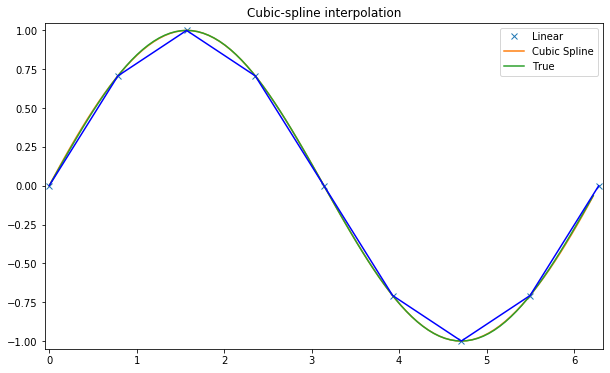

In [28]:
plt.figure(figsize=(10,6))
plt.plot(x, y, 'x', xnew, ynew, xnew, np.sin(xnew), x, y, 'b')
plt.legend(['Linear', 'Cubic Spline', 'True'])
plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')
plt.show()

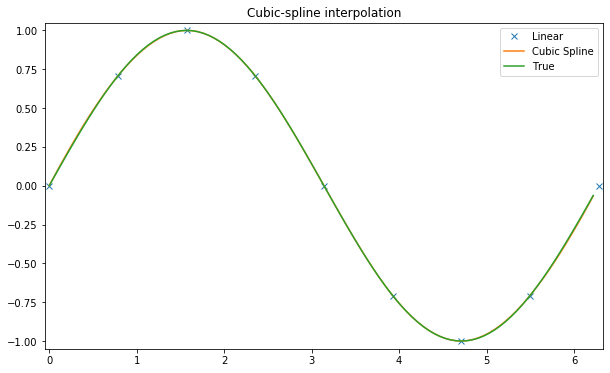

In [31]:
plt.figure(figsize=(10,6))
#plt.plot(x, y, 'x', xnew, ynew, xnew, np.sin(xnew), x, y, 'b')
plt.plot(x, y, 'x')
plt.plot(xnew, ynew) 
plt.plot(xnew, np.sin(xnew))#, x, y, 'b')
plt.legend(['Linear', 'Cubic Spline', 'True'])
plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')
plt.show()

<font face="Calibri" size=4>Part III. Risk Factors Simulation
</font>
- ### Simulation Methodolody
- ### Calibration to Market Data
- ### Simulation: 3 years, 1 month time step, $M$ simulations

<font face="Calibri" size=4>Part IV. Calculation of Expoected Exposure Profiles
</font>
- ### Expected Exposure (EE) profile for each derivative in question
- ### Identification and presentation of the key features of EE, per derivative
- ### Sensitivity analysis of volatility changes, on Expected Exposure

<font face="Calibri" size=4>Part V. CVA Calculation for Each Derivative
</font>
- ### CVA per derivative
- ### Sensitivity analysis of volatility changes on CVA